In [2]:
import pandas as pd
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [3]:
import anndata as ad

In [4]:
import os
os.getcwd()

'/home/y_pc/celltypist_env'

In [12]:
GSE183276_raw_adata = ad.read_h5ad(
    "/mnt/c/Users/My pc/OneDrive/Documents/GSE183276/demo/output/03_GSE183276_seurat_pca_umap.h5ad"
)

GSE183276_raw_adata


AnnData object with n_obs × n_vars = 5405 × 16442
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Condition', 'percent.mt', 'percent.rb', 'Sample', 'mahal_dist_nCount', 'pca_clusters', 'ident'
    uns: 'X_name'
    obsm: 'PCA', 'UMAP'
    layers: 'logcounts'

In [13]:
GSE183276_harmony_adata = ad.read_h5ad(
    "/mnt/c/Users/My pc/OneDrive/Documents/GSE183276/demo/output/04_GSE183276_harmony_corrected.h5ad"
)

GSE183276_harmony_adata


AnnData object with n_obs × n_vars = 5405 × 16442
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Condition', 'percent.mt', 'percent.rb', 'Sample', 'mahal_dist_nCount', 'pca_clusters', 'harmony_nn_res.0.8', 'seurat_clusters', 'ident'
    uns: 'X_name'
    obsm: 'HARMONY', 'PCA', 'UMAP'
    layers: 'logcounts'

(5405, 2)


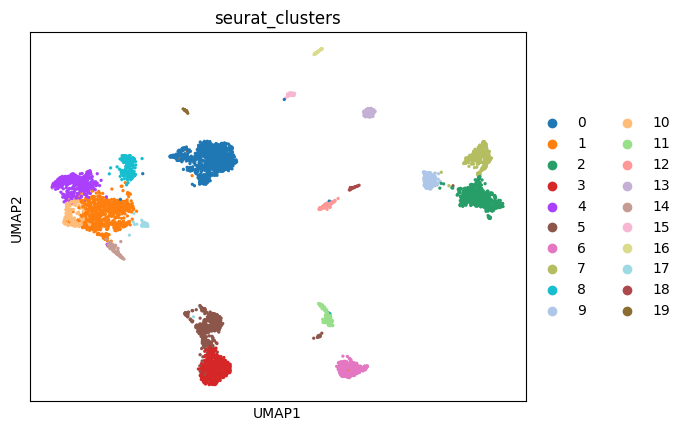

In [14]:
import numpy as np
import pandas as pd
import scanpy as sc

# Load Seurat UMAP coordinates
umap_df = pd.read_csv(
    "/mnt/c/Users/My pc/OneDrive/Documents/GSE183276/GSE183276_umap_coordinates.csv",
    index_col=0
)

# Sanity check
print(umap_df.shape)   # should be (5405, 2)

# Inject into AnnData
GSE183276_harmony_adata.obsm['X_umap'] = umap_df.loc[
    GSE183276_harmony_adata.obs_names
].values

# Plot
sc.pl.umap(
    GSE183276_harmony_adata,
    color='seurat_clusters',
    show=True
)


In [15]:
# Put log-normalized counts into X (only for CellTypist)
GSE183276_harmony_adata.X = GSE183276_harmony_adata.layers['logcounts'].copy()

In [16]:
import celltypist

/home/y_pc/celltypist_env/lib/python3.12/site-packages/celltypist/classifier.py:11: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  from scanpy import __version__ as scv


In [17]:
ct_pred = celltypist.annotate(
    GSE183276_harmony_adata,
    model="/mnt/d/University of Hyderabad/Sem 2/RNA seq training/working dataset/Adult_Human_Kidney.pkl",
    majority_voting=True
)


🔬 Input data has 5405 cells and 16442 genes
🔗 Matching reference genes in the model
🧬 9164 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
/home/y_pc/celltypist_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [18]:
GSE183276_harmony_adata.obs['majority_voting'] = (
    ct_pred.predicted_labels['majority_voting']
    .astype(str)
)

In [19]:
print(GSE183276_harmony_adata.obs['majority_voting'].value_counts().head())

majority_voting
aTAL      836
PC        703
EC-PTC    536
aPT       490
C-TAL     468
Name: count, dtype: int64


In [20]:
import matplotlib.pyplot as plt

In [23]:
import os

outdir = "/mnt/c/Users/My pc/OneDrive/Documents/GSE183276/demo/plots/celltypist_plot"
os.makedirs(outdir, exist_ok=True)


... storing 'majority_voting' as categorical


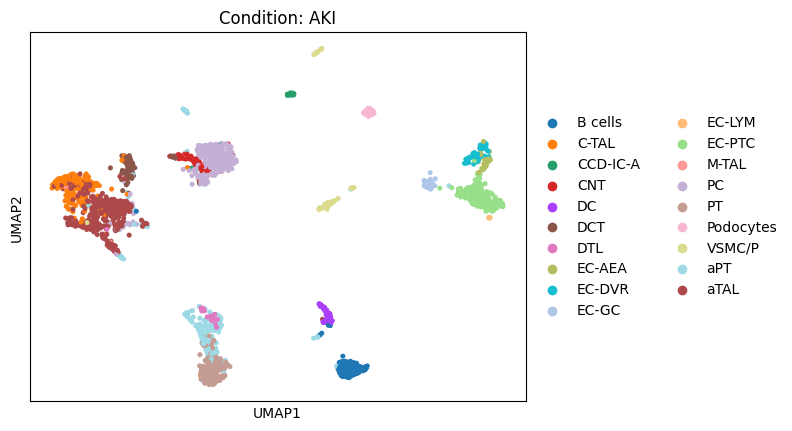

... storing 'majority_voting' as categorical


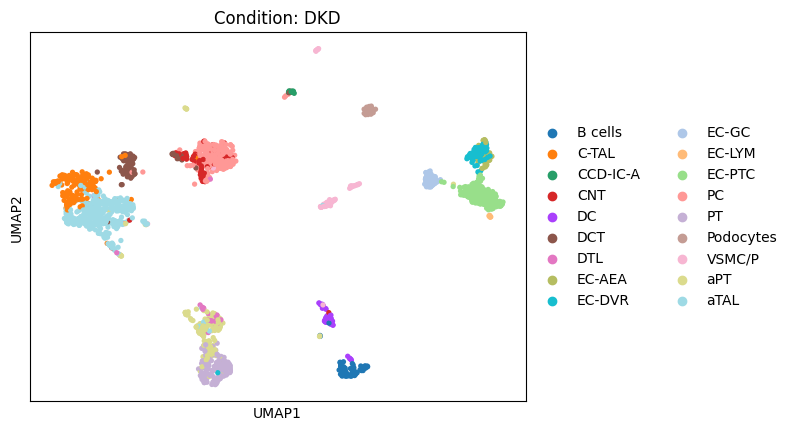

... storing 'majority_voting' as categorical


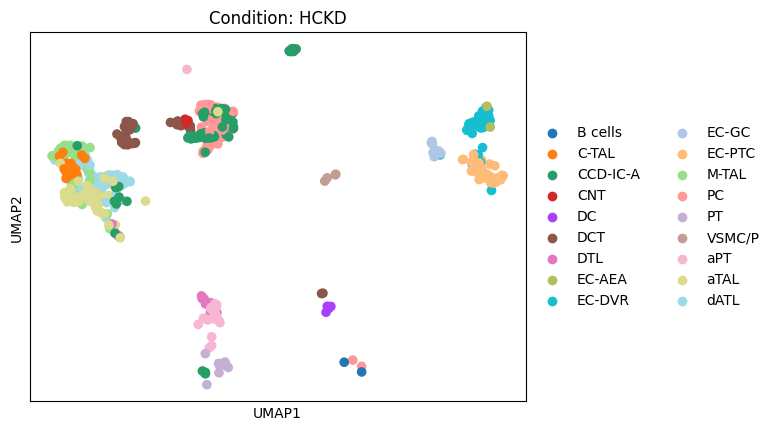

... storing 'majority_voting' as categorical


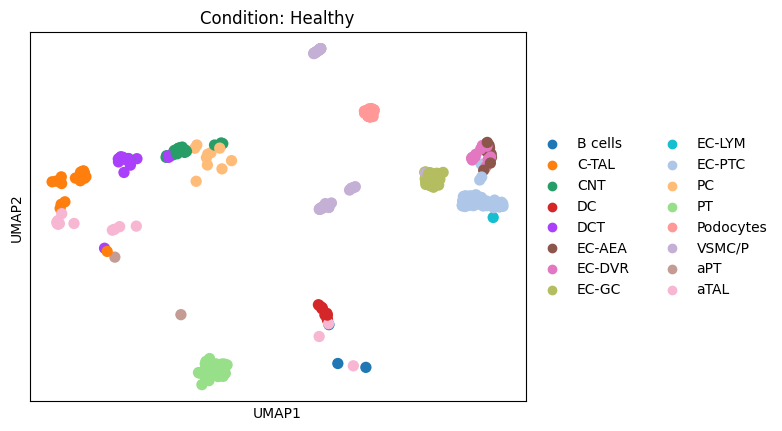

In [24]:
import matplotlib.pyplot as plt

for cond in GSE183276_harmony_adata.obs['Condition'].unique():
    fig = sc.pl.umap(
        GSE183276_harmony_adata[
            GSE183276_harmony_adata.obs['Condition'] == cond
        ],
        color='majority_voting',
        title=f'Condition: {cond}',
        legend_loc='right margin',
        show=False,
        return_fig=True
    )

    plt.savefig(
        f"/mnt/c/Users/My pc/OneDrive/Documents/GSE183276/demo/plots/celltypist_plot/umap_celltypes_ct_{cond}.png",
        dpi=300,
        bbox_inches='tight'
    )

    plt.show()


In [25]:
# Move log-normalized expression into X for CellTypist
GSE183276_raw_adata.X = GSE183276_raw_adata.layers['logcounts'].copy()

GSE183276_predictions3 = celltypist.annotate(
    GSE183276_raw_adata, 
    model="/mnt/d/University of Hyderabad/Sem 2/RNA seq training/working dataset/Adult_Human_Kidney.pkl",
    majority_voting=True
)

# Save majority voting to obs
GSE183276_raw_adata.obs["majority_voting"] = (
    GSE183276_predictions3.predicted_labels["majority_voting"].astype(str)
)


🔬 Input data has 5405 cells and 16442 genes
🔗 Matching reference genes in the model
🧬 9164 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [26]:
import seaborn as sns

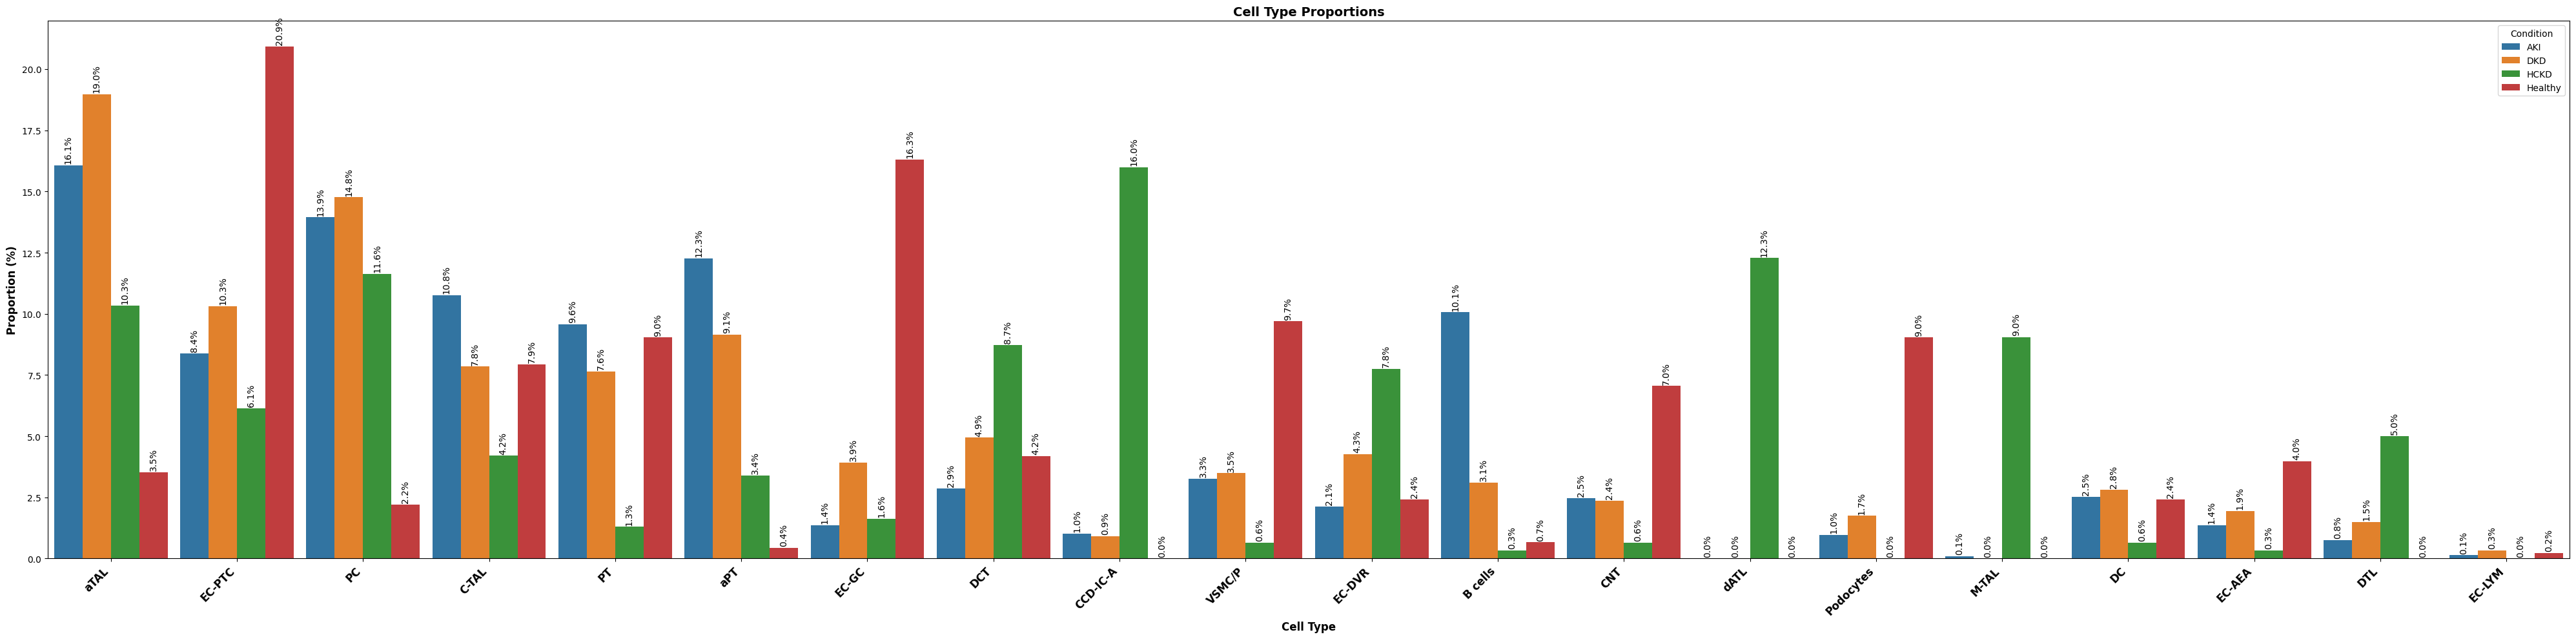

In [27]:
# Step 1: Count cells per cell type per condition
n_cells_condition = (
    GSE183276_raw_adata.obs
    .groupby(["Condition", "majority_voting"])
    .size()
    .reset_index(name="count")
)

# Step 2: Calculate proportions per condition
n_cells_condition["total"] = n_cells_condition.groupby("Condition")["count"].transform("sum")
n_cells_condition["proportion"] = (n_cells_condition["count"] / n_cells_condition["total"]) * 100

# Step 3: Compute average proportion per cell type for ordering
avg_proportions = (
    n_cells_condition
    .groupby("majority_voting")["proportion"]
    .mean()
    .sort_values(ascending=False)
)
ordered_celltypes = avg_proportions.index.tolist()

# Step 4: Plot
plt.figure(figsize=(40, 10))
ax = sns.barplot(
    data=n_cells_condition,
    x="majority_voting",
    y="proportion",
    hue="Condition",
    order=ordered_celltypes,
    dodge=True,
    width=0.9
)

# Step 5: Add proportion labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge',
                 padding=2, fontsize=10, rotation=90)

# Customize axes
plt.xticks(rotation=45, ha="right", fontsize=12, fontweight="bold")
plt.ylabel("Proportion (%)", fontsize=12, fontweight="bold")
plt.xlabel("Cell Type", fontsize=12, fontweight="bold")
plt.title("Cell Type Proportions", fontsize=14, fontweight="bold")
plt.tight_layout()

# ✅ Save to YOUR folder
plt.savefig(
    "/mnt/c/Users/My pc/OneDrive/Documents/GSE183276/demo/plots/Cellproportions_barplot.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()

# ✅ Save CSV to same folder
n_cells_condition.to_csv(
    "/mnt/c/Users/My pc/OneDrive/Documents/GSE183276/demo/plots/Cellproportions.csv",
    index=False
)


In [28]:
# Create combined group label FIRST
GSE183276_raw_adata.obs['majority_voting'] = (
    GSE183276_raw_adata.obs['majority_voting'].astype(str)
    + "_" +
    GSE183276_raw_adata.obs['Condition'].astype(str)
)

In [29]:
def find_unique_markers(
    adata, 
    groupby='cell_type', 
    method='wilcoxon', 
    pval_threshold=0.05, 
    logfc_threshold=0.25,
    top_n=3,
    min_cells_per_group=2
):
    """
    Mimics Seurat's FindAllMarkers + filters for unique DEGs per cluster.
    
    Parameters:
        adata : AnnData object
        groupby : column in adata.obs to group cells (e.g., clusters, cell_type)
        method : DEG test method ('wilcoxon', 't-test', 'logreg')
        pval_threshold : adjusted p-value threshold for significance
        logfc_threshold : log fold change threshold for filtering

    Returns:
        unique_degs_df : DataFrame of DEGs unique to each group
    """

    # Filter out low-cell groups
    group_counts = adata.obs[groupby].value_counts()
    valid_groups = group_counts[group_counts >= min_cells_per_group].index.tolist()

    # Subset AnnData to valid groups only
    adata_filtered = adata[adata.obs[groupby].isin(valid_groups)].copy()
    
    # Run DEG analysis
    sc.tl.rank_genes_groups(adata_filtered, groupby=groupby, method=method)
    
    # Get full results into a DataFrame
    all_degs = sc.get.rank_genes_groups_df(adata_filtered, group=None)
    
    # Filter by significance
    filtered_degs = all_degs[
        (all_degs['pvals_adj'] < pval_threshold) &
        (abs(all_degs['logfoldchanges']) > logfc_threshold)
    ]

    # Find genes that appear in only one group
    unique_genes = (
        filtered_degs.groupby('names')['group']
        .nunique()
        .reset_index()
        .query('group == 1')['names']
        .tolist()
    )

    # Keep only unique DEGs
    unique_degs_df = filtered_degs[filtered_degs['names'].isin(unique_genes)].copy()


    # Select top N per group by logFC
    top_unique_degs_df = (
        unique_degs_df
        .sort_values(['group', 'logfoldchanges'], ascending=[True, False])
        .groupby('group')
        .head(top_n)
        .reset_index(drop=True)
    )

    return top_unique_degs_df

In [30]:
unique_markers = find_unique_markers(
    GSE183276_raw_adata, 
    groupby='majority_voting',
    method='wilcoxon',
    pval_threshold=0.05, 
    logfc_threshold=0.25,
    top_n=3, 
    min_cells_per_group=2
)

unique_markers['group'] = (
    unique_markers['group']
    .str.replace(r'_(HCKD|Healthy|AKI|DKD)_\1$', r'_\1', regex=True)
)

# Inspect & save
print(unique_markers.head())
unique_markers['group'].drop_duplicates()

unique_markers.to_csv("Unique_cluster_markers.csv", index=False)

... storing 'majority_voting' as categorical


         group    names    scores  logfoldchanges     pvals  pvals_adj
0  B cells_AKI     LAX1  3.645379        6.460696  0.000267   0.002188
1  B cells_AKI  PKHD1L1  4.743714        6.436535  0.000002   0.000027
2  B cells_AKI    IKZF3  3.308039        6.278649  0.000940   0.006601
3  B cells_DKD    AMPD1  4.031142        6.664078  0.000056   0.002065
4  B cells_DKD    KLHL6  3.348424        5.574310  0.000813   0.020186


... storing 'majority_voting' as categorical


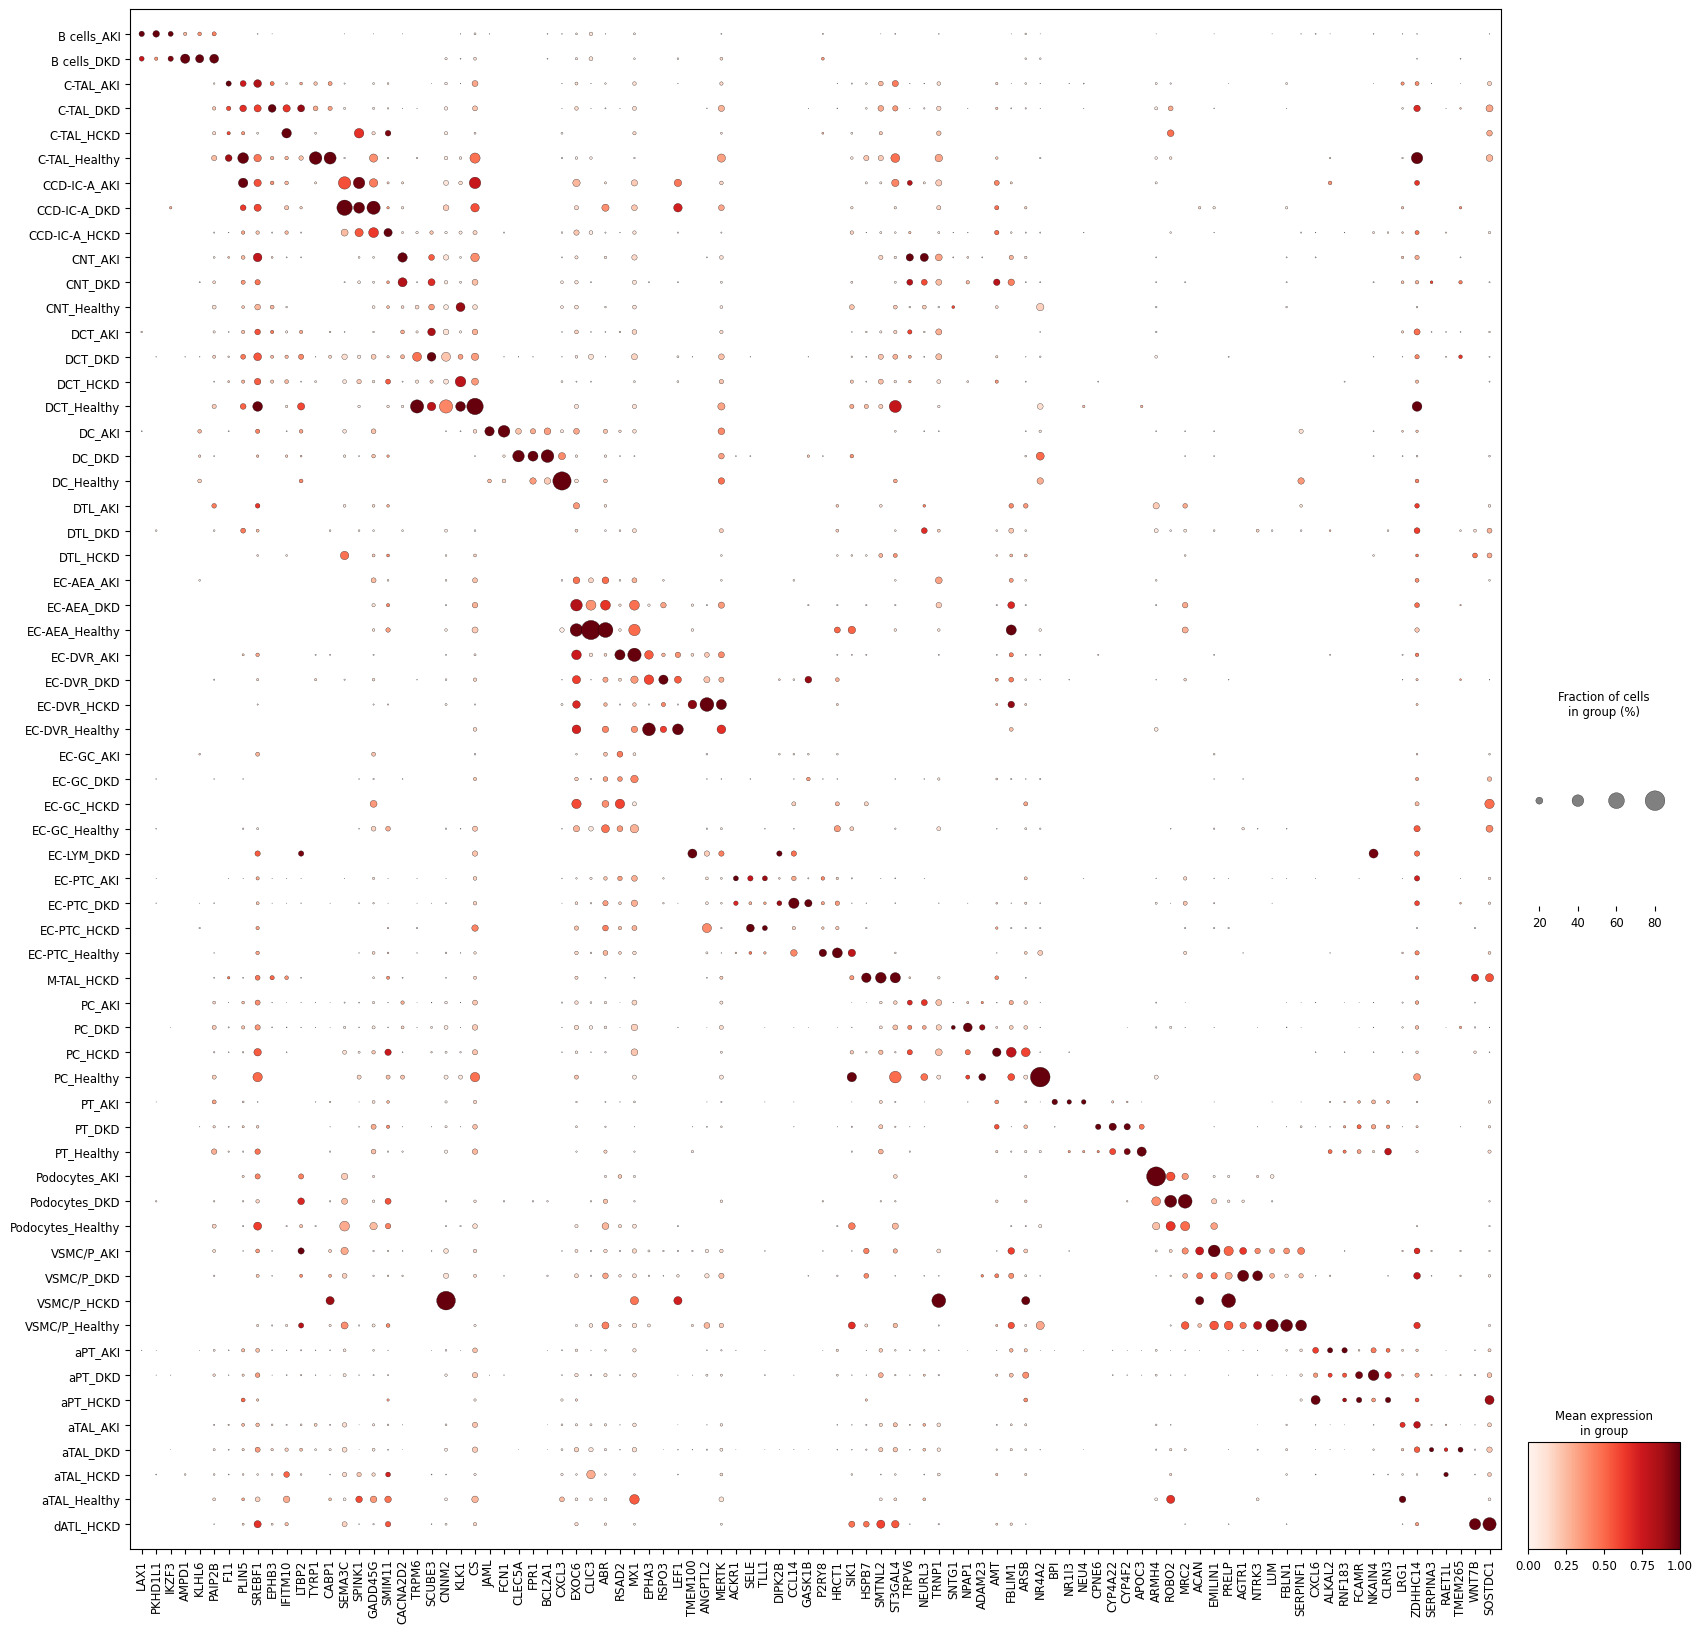

In [31]:
excluded_prefixes = ["Classical monocytes"]
mask = ~GSE183276_raw_adata.obs['majority_voting'].str.startswith(tuple(excluded_prefixes))
adata_to_plot = GSE183276_raw_adata[mask].copy()

genes_to_plot = unique_markers["names"].tolist()  # top 3 per group
# Keep only genes that exist in adata.var_names
genes_to_plot = [g for g in genes_to_plot if g in adata_to_plot.var_names]

X = adata_to_plot[:, genes_to_plot].X
if hasattr(X, "toarray"):  # sparse -> dense
    X = X.toarray()

# Make a DataFrame: rows = cell types, columns = genes
expr_df = pd.DataFrame(X, index=adata_to_plot.obs['majority_voting'], columns=genes_to_plot)

expr_per_group = expr_df.groupby(expr_df.index).sum()  # rows = groups, columns = genes

# Keep only genes where max across groups ≥ 30
genes_filtered = expr_per_group.columns[(expr_per_group.max(axis=0) >= 30)].tolist()

# Filter expression DataFrame
expr_per_group = expr_per_group[genes_filtered]

valid_groups = expr_per_group.index[(expr_per_group.sum(axis=1) > 20)].tolist()
adata_to_plot = adata_to_plot[adata_to_plot.obs['majority_voting'].isin(valid_groups)].copy()

sc.pl.dotplot(
    adata_to_plot,
    var_names=genes_filtered,
    groupby='majority_voting',
    standard_scale='var',
    show=False,
    figsize=(20, 20),
    dendrogram=False
)
plt.savefig("/mnt/c/Users/My pc/OneDrive/Documents/GSE183276/demo/plots/Cluster_Markergenes.png", dpi=300, bbox_inches='tight')
plt.show()